In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import genpareto, bootstrap
from sklearn.utils import resample
import cartopy.crs as ccrs

# Python3 code to remove spaces from string
def remove(string):
    return string.replace(" ", "")

In [2]:
pwd = '/Users/tweetybaldwin/Dropbox/RESEARCH/Worldbank/REVISION_SCRIPTS'

# Region information

In [4]:
pickle_in = open("/home/jbaldwin/WorldBank/REGION_MASKS/state_ids.p","rb")
state_ids = pickle.load(pickle_in)
regions = list(state_ids.keys())

regions_sel = ['Eastern Visayas','NCR']

In [5]:
# Load data synthetic
ds = {}
wind = {}
asset = {}
dyear = {}
for reg in regions_sel:
    ds[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/CHAZ/ERAInterim_WPC/PHI_REGION_METRICS/'+remove(reg)+'.nc')
    wind[reg] = ds[reg].max_wind
    asset[reg] = ds[reg].asset_losses
    dyear[reg] = ds[reg].dyear

In [5]:
# Load data historical
ds_wind_hist = {}
ds_asset_hist = {}
wind_hist = {}
asset_hist = {}
dyear_hist = {}
for reg in regions_sel:
    ds_wind_hist[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/PROVINCE_METRICS/maxwind_'+remove(reg)+'.nc')
    wind_hist[reg] = ds_wind_hist[reg].max_wind
    dyear_hist[reg] = ds_wind_hist[reg].period_years
    ds_asset_hist[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/PROVINCE_METRICS/assetlosses_'+remove(reg)+'.nc')
    asset_hist[reg] = ds_asset_hist[reg].asset_losses


In [6]:
def exceedance(data,dyear,plotattrs,marker,label,linewidth):
    pdfevents,bins = np.histogram(data,np.unique(np.hstack([np.sort(data),data.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/dyear # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    dot, = ax.semilogx(returnP_o[:],bins[:-1],plotattrs,marker=marker,label=label,linewidth=linewidth)

# Function to calculate GPD fit. Returns return periods corresponding to x-values of interest.
def gpd_fit(x,dat,dyear):
    shape,loc,scale = genpareto.fit(dat) # shape,loc,scale
    rv = genpareto(shape,loc,scale)
    cdfevents = (1-rv.cdf(x))*(len(dat)/dyear)
    rp = 1/cdfevents
    return rp

# Create bootstrap samples
def bootstrap_samples(dat, n_samples):
    shape = np.shape(dat)
    x = dat
    xstar = np.empty([shape[0],n_samples])
    for n in np.arange(n_samples):
        xstar[:,n] = resample(x,replace=True)
    return xstar

# Calculates gpd fit and confidence intervals using bootstrapping.
# Requires function gpd_fit and bootstrap samples above.
def gpd_confidence_interval(x,dat,dyear,n_samples,ci):
    # n_samples = number of times resample to create sample of same size as dataset (switch to 100 later)
    # ci = 0.05 # 0.05 (5%) on top and bottom to create 90% confidence intervals
    # x = values to calculate return periods for
    # dat = sample of data to calculate statistics for
    # dyear = duration in years of sample of data
    
    # Calculate return periods for original data
    rp0 = gpd_fit(x,dat,dyear)

    # Resample data with replacement
    xstar = bootstrap_samples(dat, n_samples)

    # Calculate return periods for resamples
    rp = np.zeros([np.shape(x)[0],n_samples])
    for i in range(n_samples):
        rp[:,i] = gpd_fit(x,xstar[:,i],dyear)

    # Produce upper and lower return period confidence interval
    rpdiff = rp-np.repeat(rp0[:, np.newaxis],n_samples,axis=1)
    ci_u = rp0+np.quantile(rpdiff,1-ci,axis=1)
    ci_l = rp0+np.quantile(rpdiff,ci,axis=1)
    
    return rp0, ci_u, ci_l


In [7]:
%%time
# Calculate GPD fits for wind data
n_samples = 1000
ci = 0.05
thres = 10 # cut off at threshold of 10 m/s for GPD fit

# Wind values to calculate return periods for
x_wind = {}
x_wind['NCR'] = np.arange(0,110,5)
x_wind['Eastern Visayas'] = np.arange(0,110,5)

rp0 = {}
ci_u  = {}
ci_l = {}
for reg in ['NCR','Eastern Visayas']:
    data0 = wind_hist[reg].values
    data = data0[data0>thres]
    rp0[reg], ci_u[reg], ci_l[reg] = gpd_confidence_interval(x_wind[reg],data,dyear_hist[reg],n_samples,ci)

/var/folders/vr/f32dcwsj6p50533shyzfz5fh0000gn/T/ipykernel_66939/2776217219.py:12: RuntimeWarning: divide by zero encountered in true_divide
  rp = 1/cdfevents
/Users/tweetybaldwin/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


CPU times: user 3min 48s, sys: 2.08 s, total: 3min 50s
Wall time: 3min 54s


In [ ]:
%%time
# Calculate GPD fits for asset loss data
n_samples = 1000
ci = 0.05
thres = 1e5 # cut off at threshold of $100k for GPD fit

# Loss values to calculate return periods for
x_asset = {}
x_asset['NCR'] = np.linspace(0,8e9,20)
x_asset['Eastern Visayas'] = np.linspace(0,2e9,20)

rp0_asset = {}
ci_u_asset  = {}
ci_l_asset = {}
for reg in ['NCR','Eastern Visayas']:
    data0 = asset_hist[reg].values
    data = data0[data0>thres]
    rp0_asset[reg], ci_u_asset[reg], ci_l_asset[reg] = gpd_confidence_interval(x_asset[reg],data,dyear_hist[reg],n_samples,ci)

# Plot exceedance curves for maximum wind speed & asset losses

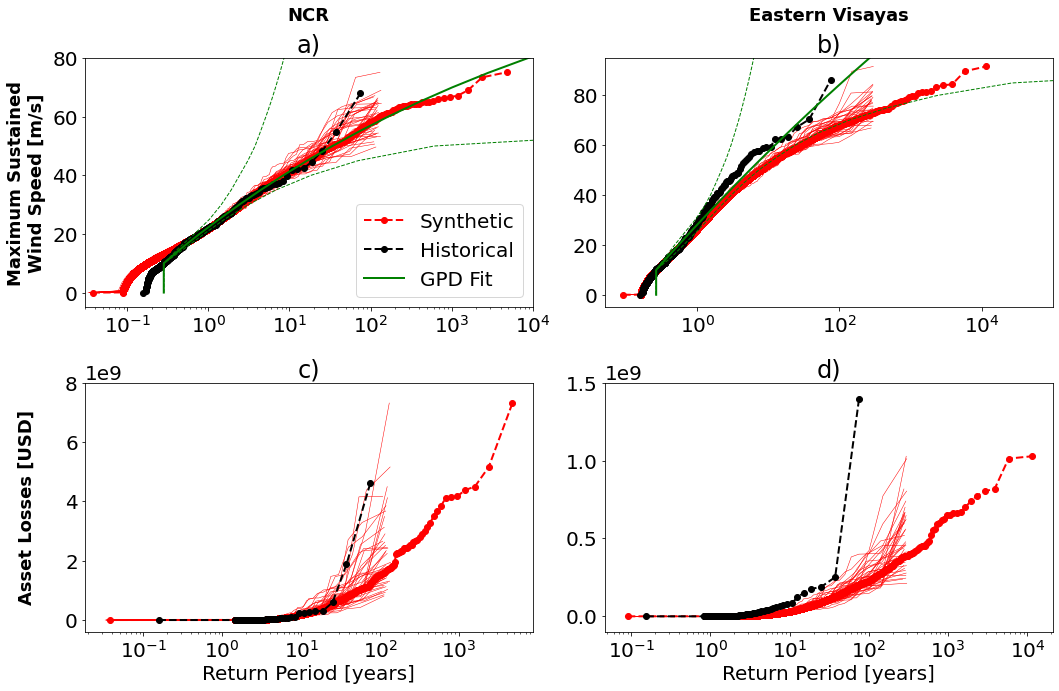

In [9]:
fig = plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 20})

ax = plt.subplot(221)
reg = 'NCR'
for i in np.arange(0,wind[reg].ensembleNum.max().values,1):
    exceedance(wind[reg].sel(ensembleNum=i),dyear[reg].sel(ensembleNum=i).values,'r-','','',0.5)
exceedance(wind[reg].values.ravel(),dyear[reg].sum(dim='ensembleNum').values,'r--','o','Synthetic',2)
exceedance(wind_hist[reg],dyear_hist[reg],'k--','o','Historical',2)
ax.semilogx(rp0[reg], x_wind[reg], 'g', lw=2, label = 'GPD Fit')
ax.semilogx(ci_u[reg], x_wind[reg], 'g--', lw=1)
ax.semilogx(ci_l[reg], x_wind[reg], 'g--', lw=1)
plt.title('a)')
#plt.xlabel('Return Period [years]')
#plt.ylabel('Maximum Sustained Wind Speed\n[m/s]',fontsize = 16)
plt.legend()
ax.text(0.5,1.15,'NCR',fontsize=18,transform=ax.transAxes,fontweight='bold',horizontalalignment='center')
ax.text(-0.13,0.5,'Maximum Sustained\nWind Speed [m/s]',fontsize=18,transform=ax.transAxes,fontweight='bold',verticalalignment='center',rotation='vertical',horizontalalignment='center')
plt.ylim([-5,80])
plt.xlim([0.03,1e4])

ax = plt.subplot(222)
reg = 'Eastern Visayas'
for i in np.arange(0,wind[reg].ensembleNum.max().values,1):
    exceedance(wind[reg].sel(ensembleNum=i),dyear[reg].sel(ensembleNum=i).values,'r-','','',0.5)
exceedance(wind[reg].values.ravel(),dyear[reg].sum(dim='ensembleNum').values,'r--','o','Synthetic',2)
exceedance(wind_hist[reg],dyear_hist[reg],'k--','o','Historical',2)
ax.semilogx(rp0[reg], x_wind[reg], 'g', lw=2)
ax.semilogx(ci_u[reg], x_wind[reg], 'g--', lw=1)
ax.semilogx(ci_l[reg], x_wind[reg], 'g--', lw=1)
plt.title('b)' )
#plt.xlabel('Return Period [years]')
#plt.ylabel('Maximum Sustained Wind Speed\n[m/s]',fontsize = 16)
ax.text(0.5,1.15,'Eastern Visayas',fontsize=18,transform=ax.transAxes,fontweight='bold',horizontalalignment='center')
plt.ylim([-5,95])
plt.xlim([0.05,1e5])

ax = plt.subplot(223)
reg = 'NCR'
for i in np.arange(0,asset[reg].ensembleNum.max().values,1):
    exceedance(asset[reg].sel(ensembleNum=i),dyear[reg].sel(ensembleNum=i).values,'r-','','',0.5)
exceedance(asset[reg].values.ravel(),dyear[reg].sum(dim='ensembleNum').values,'r--','o','Synthetic',2)
exceedance(asset_hist[reg],dyear_hist[reg],'k--','o','Historical',2)
# ax.semilogx(rp0_asset[reg], x_asset[reg], 'g', lw=2)
# ax.semilogx(ci_u_asset[reg], x_asset[reg], 'g--', lw=1)
# ax.semilogx(ci_l_asset[reg], x_asset[reg], 'g--', lw=1)
plt.title('c)')
plt.xlabel('Return Period [years]')
#plt.ylabel('Asset Losses [USD]')
ax.text(-0.13,0.5,'Asset Losses [USD]',fontsize=18,transform=ax.transAxes,fontweight='bold',verticalalignment='center',rotation='vertical',horizontalalignment='center')
plt.ylim([-4e8,8e9])

ax = plt.subplot(224)
reg = 'Eastern Visayas'
for i in np.arange(0,asset[reg].ensembleNum.max().values,1):
    exceedance(asset[reg].sel(ensembleNum=i),dyear[reg].sel(ensembleNum=i).values,'r-','','',0.5)
exceedance(asset[reg].values.ravel(),dyear[reg].sum(dim='ensembleNum').values,'r--','o','Synthetic',2)
exceedance(asset_hist[reg],dyear_hist[reg],'k--','o','Historical',2)
# ax.semilogx(rp0_asset[reg], x_asset[reg], 'g', lw=2)
# ax.semilogx(ci_u_asset[reg], x_asset[reg], 'g--', lw=1)
# ax.semilogx(ci_l_asset[reg], x_asset[reg], 'g--', lw=1)
plt.title('d)')
plt.xlabel('Return Period [years]')
#plt.ylabel('Asset Losses [USD]')
plt.ylim([-1e8,1.5e9])

plt.tight_layout()
plt.savefig('FIGURES/exceedance_curves.png',dpi=600)
# plt.savefig('FIGURES/exceedance_curves.pdf')

# Make maps of return period (4 panels --> 10,20,50,100)
* Need to add ARMM which didn't run out properly for wind speed and then losses = 0 as a result

In [15]:
# Load data synthetic
ds = {}
wind = {}
asset = {}
dyear = {}
for reg in regions:
    ds[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/CHAZ/ERAInterim_WPC/PHI_REGION_METRICS/'+remove(reg)+'.nc')
    wind[reg] = ds[reg].max_wind
    asset[reg] = ds[reg].asset_losses
    dyear[reg] = ds[reg].dyear

In [16]:
def exceedance_calc(data,dyear):
    pdfevents,bins = np.histogram(data,np.unique(np.hstack([np.sort(data),data.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/dyear # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    #dot, = ax.semilogx(returnP_o[:],bins[:-1],plotattrs,marker=marker,label=label,linewidth=linewidth)
    return returnP_o, bins


In [19]:
# Determine values corresponding to specific return periods

val_wind = {}
rp_targets = [10,20,50,100]

for reg in regions[1:]: # skip ARMM
    returnP_o, bins = exceedance_calc(wind[reg].values.ravel(),dyear[reg].sum(dim='ensembleNum').values)
    rp = returnP_o
    values = bins[:-1]
    val_wind[reg] = np.full(np.shape(rp_targets),np.nan)
    for i in np.arange(np.shape(rp_targets)[0]):
        n = rp_targets[i]
        ind = np.where(np.abs(rp-n) == np.min(np.abs(rp-n)))[0][0]
        val_wind[reg][i] = values[ind]
        
val_asset = {}

for reg in regions[1:]: # skip ARMM
    returnP_o, bins = exceedance_calc(asset[reg].values.ravel(),dyear[reg].sum(dim='ensembleNum').values)
    rp = returnP_o
    values = bins[:-1]
    val_asset[reg] = np.full(np.shape(rp_targets),np.nan)
    for i in np.arange(np.shape(rp_targets)[0]):
        n = rp_targets[i]
        ind = np.where(np.abs(rp-n) == np.min(np.abs(rp-n)))[0][0]
        val_asset[reg][i] = values[ind]

In [27]:
# Load Philippines province masks

d_mask = xr.open_dataset('/home/jbaldwin/WorldBank/REGION_MASKS/philippines_province_masks_newlitpopgrid.nc')


wind_map_reg = {}
loss_map_reg = {}
# Assign return level to different regions
for i in np.arange(np.shape(rp_targets)[0]):
    n = rp_targets[i]
    wind_map_reg[n] = xr.Dataset.copy(d_mask)
    loss_map_reg[n] = xr.Dataset.copy(d_mask)
    #Fix for the fact that ARMM did not run out properly    
    wind_map_reg[n].states.values[wind_map_reg[n].states==state_ids['ARMM']] = np.nan
    loss_map_reg[n].states.values[loss_map_reg[n].states==state_ids['ARMM']] = np.nan
    for reg in list(regions)[1:]:
        wind_map_reg[n].states.values[wind_map_reg[n].states==state_ids[reg]] = val_wind[reg][i]
        loss_map_reg[n].states.values[loss_map_reg[n].states==state_ids[reg]] = val_asset[reg][i]
          

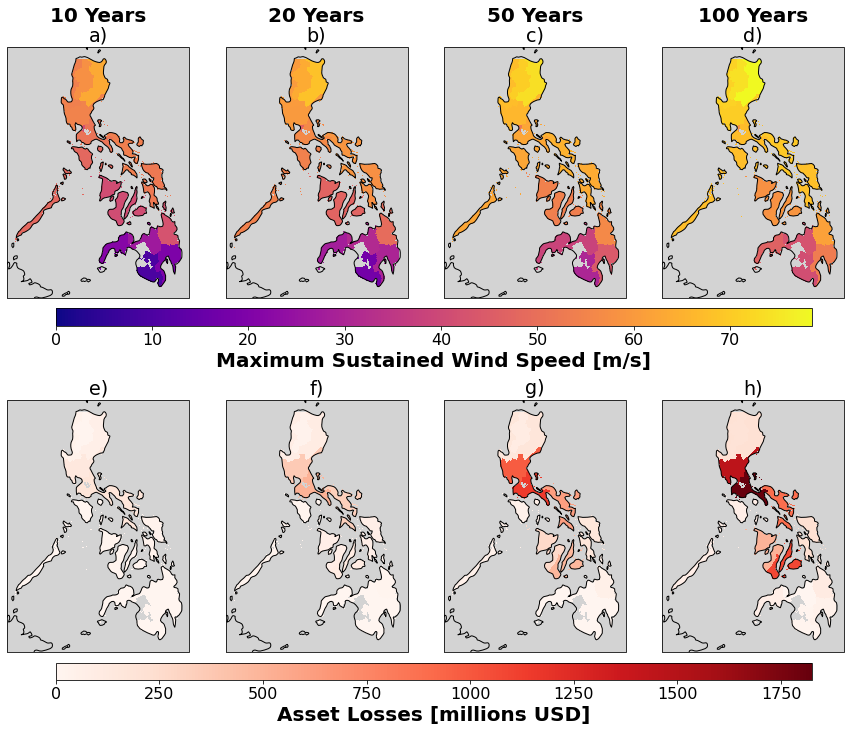

In [31]:
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 16})

loss_cmap = plt.cm.Reds
wind_cmap = plt.cm.plasma
loss_factor = 1e6
wind_vmax = float(wind_map_reg[100].max().states.values)
loss_vmax = float(loss_map_reg[100].max().states.values)/loss_factor
facecolor = 'lightgrey'


ax = plt.subplot(241,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = wind_map_reg[10].states.plot(transform=ccrs.PlateCarree(), add_colorbar = False,cmap = wind_cmap, vmin = 0, vmax = wind_vmax)
plt.title('a)')
ax.text(0.5, 1.1, '10 Years', fontsize=20,transform=ax.transAxes,horizontalalignment='center',fontweight='bold')
ax.coastlines('50m')

ax = plt.subplot(242,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = wind_map_reg[20].states.plot(transform=ccrs.PlateCarree(), add_colorbar = False,cmap = wind_cmap, vmin = 0, vmax = wind_vmax)
plt.title('b)')
ax.text(0.5, 1.1, '20 Years', fontsize=20,transform=ax.transAxes,horizontalalignment='center',fontweight='bold')
ax.coastlines('50m')

ax = plt.subplot(243,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = wind_map_reg[50].states.plot(transform=ccrs.PlateCarree(), add_colorbar = False,cmap = wind_cmap, vmin = 0, vmax = wind_vmax)
plt.title('c)')
ax.text(0.5, 1.1, '50 Years', fontsize=20,transform=ax.transAxes,horizontalalignment='center',fontweight='bold')
ax.coastlines('50m')

ax = plt.subplot(244,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = wind_map_reg[100].states.plot(transform=ccrs.PlateCarree(), add_colorbar = False, cmap = wind_cmap, vmin = 0, vmax = wind_vmax)
plt.title('d)')
ax.text(0.5, 1.1, '100 Years', fontsize=20,transform=ax.transAxes,horizontalalignment='center',fontweight='bold')
ax.coastlines('50m')

#COLORBAR FOR WIND
fig.subplots_adjust(hspace=0.18)
cbar_ax = fig.add_axes([0.17, 0.53, 0.7, 0.02]) # x pos, y pos, x width, y width
cb = fig.colorbar(p, cax=cbar_ax, orientation = 'horizontal')
cb.set_label(label='Maximum Sustained Wind Speed [m/s]',fontweight='bold',fontsize=20)

ax = plt.subplot(245,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = (loss_map_reg[10].states/loss_factor).plot(transform=ccrs.PlateCarree(), add_colorbar = False, cmap = loss_cmap, vmin = 0, vmax = loss_vmax)
plt.title('e)')
ax.coastlines('50m')

ax = plt.subplot(246,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = (loss_map_reg[20].states/loss_factor).plot(transform=ccrs.PlateCarree(), add_colorbar = False, cmap = loss_cmap, vmin = 0, vmax = loss_vmax)
plt.title('f)')
ax.coastlines('50m')

ax = plt.subplot(247,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = (loss_map_reg[50].states/loss_factor).plot(transform=ccrs.PlateCarree(), add_colorbar = False, cmap = loss_cmap, vmin = 0, vmax = loss_vmax)
plt.title('g)')
ax.coastlines('50m')

ax = plt.subplot(248,projection=ccrs.PlateCarree())
ax.set_facecolor(facecolor)
p = (loss_map_reg[100].states/loss_factor).plot(transform=ccrs.PlateCarree(), add_colorbar = False, cmap = loss_cmap, vmin = 0, vmax = loss_vmax)
plt.title('h)')
ax.coastlines('50m')

# COLORBAR FOR LOSSES
cbar_ax = fig.add_axes([0.17, 0.12, 0.7, 0.02]) # x pos, y pos, x width, y width
cb = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cb.set_label(label='Asset Losses [millions USD]',fontweight='bold',fontsize=20)

plt.savefig('FIGURES/returnlevel_maps.png',dpi=600)
#plt.savefig('FIGURES/returnlevel_maps.pdf')

# SCRATCH: Developing GPD fit to historical losses
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html

Question: is my selection of thresholds appropriate? should threshold be used here even though these are extreme events already? I think so given that some events do not result in losses in a given region.

Steps:
* Fit GPD to all data
* Produce points corresponding to fit and plot 
* Fit GPD to samples of data with replacement (bootstrap)
* Produce points corresponding to fit and plot  
* Calculate 90% confidence interval on bootstrapped data (upper and lower quantile) 

In [ ]:
%%time
# TEST IF FIT IS WORKING PROPERLY
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
dyear = dyear_hist['NCR']

# Generate synthetic data based on pareto distribution fit
shape,loc,scale = genpareto.fit(wind_hist['NCR'])
dat = genpareto.rvs(shape,loc,scale, size=1000)

# Determine GPD fit to synthetic data
x = np.arange(0,110,5)
n_samples = 1000
ci = 0.05
rp0_test, ci_u_test, ci_l_test = gpd_confidence_interval(x,dat,dyear,n_samples,ci)

# Plot exceedance curve for synthetic data in black, and fits with confidence interval in green
exceedance(dat,dyear,'k--','o','Historical',2)

ax.semilogx(rp0_test, x, 'g', lw=2)
ax.semilogx(ci_u_test, x, 'g--', lw=1)
ax.semilogx(ci_l_test, x, 'g--', lw=1)

plt.xlabel('Return Period [years]')
plt.ylabel('Wind Speed [m/s]')

plt.show()

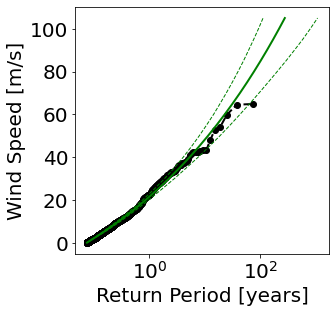

CPU times: user 1min 5s, sys: 140 ms, total: 1min 5s
Wall time: 1min 4s


In [167]:
%%time
# TEST IF FIT IS WORKING PROPERLY
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
dyear0 = dyear_hist['NCR']

# Generate synthetic data based on pareto distribution fit
shape,loc,scale = genpareto.fit(wind_hist['NCR'])
dat = genpareto.rvs(shape,loc,scale, size=1000)

# Determine GPD fit to synthetic data
x = np.arange(0,110,5)
n_samples = 1000
ci = 0.05
rp0_test, ci_u_test, ci_l_test = gpd_confidence_interval(x,dat,dyear0,n_samples,ci)

# Plot exceedance curve for synthetic data in black, and fits with confidence interval in green
exceedance(dat,dyear0,'k--','o','Historical',2)

ax.semilogx(rp0_test, x, 'g', lw=2)
ax.semilogx(ci_u_test, x, 'g--', lw=1)
ax.semilogx(ci_l_test, x, 'g--', lw=1)

plt.xlabel('Return Period [years]')
plt.ylabel('Wind Speed [m/s]')

plt.show()

<timed exec>:12: RuntimeWarning: divide by zero encountered in true_divide
/Users/tweetybaldwin/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


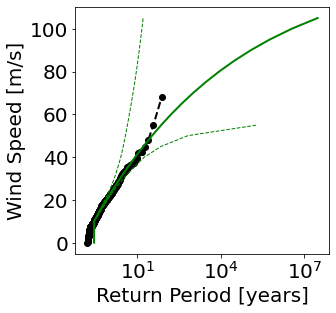

CPU times: user 11 s, sys: 104 ms, total: 11.1 s
Wall time: 10.2 s


In [191]:
%%time
# TEST IF FIT IS WORKING PROPERLY
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
dyear0 = dyear_hist['NCR']

# Threshold data
data0 = wind_hist['NCR']
data = data0[data0>10]

# Determine GPD fit to synthetic data
x = np.arange(0,110,5)
n_samples = 100
ci = 0.05
rp0_test, ci_u_test, ci_l_test = gpd_confidence_interval(x,data,dyear0,n_samples,ci)

# Plot exceedance curve for synthetic data in black, and fits with confidence interval in green
exceedance(data0,dyear0,'k--','o','Historical',2)

ax.semilogx(rp0_test, x, 'g', lw=2)
ax.semilogx(ci_u_test, x, 'g--', lw=1)
ax.semilogx(ci_l_test, x, 'g--', lw=1)

plt.xlabel('Return Period [years]')
plt.ylabel('Wind Speed [m/s]')

plt.show()

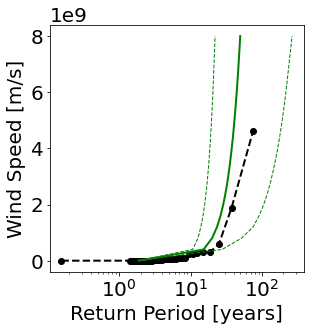

CPU times: user 11.8 s, sys: 74.1 ms, total: 11.9 s
Wall time: 10.6 s


In [232]:
%%time
# TEST IF FIT IS WORKING PROPERLY
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
dyear0 = dyear_hist['NCR']

# Threshold data
data0 = asset_hist['NCR']
data = data0[data0>1e5]

# Determine GPD fit to synthetic data
x = np.linspace(0,8e9,21)
n_samples = 100
ci = 0.05
rp0_test, ci_u_test, ci_l_test = gpd_confidence_interval(x,data,dyear0,n_samples,ci)

# Plot exceedance curve for synthetic data in black, and fits with confidence interval in green
exceedance(data0,dyear0,'k--','o','Historical',2)

ax.semilogx(rp0_test, x, 'g', lw=2)
ax.semilogx(ci_u_test, x, 'g--', lw=1)
ax.semilogx(ci_l_test, x, 'g--', lw=1)

plt.xlabel('Return Period [years]')
plt.ylabel('Wind Speed [m/s]')

plt.show()

# OLD EXCEEDANCE CURVES

In [7]:
# Load data synthetic
ds_asset_losses = {}
asset_losses = {}
vector_assets = {}
period_years = {}
for reg in regions_sel:
    ds_asset_losses[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/CHAZ/ERAInterim_WPC/PHI_PROVINCE_METRICS/wpc0-2_assetlosses_'+regions_nospace[reg]+'.nc')
    asset_losses[reg] = ds_asset_losses[reg].asset_losses
    vector_assets[reg] = np.concatenate(asset_losses[reg])
    period_years[reg] = ds_asset_losses[reg].attrs['period_years']

In [8]:
# Load data historical
ds_asset_losses_hist = {}
asset_losses_hist = {}
period_years_hist = {}
for reg in regions_sel:
    ds_asset_losses_hist[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/PROVINCE_METRICS/assetlosses_'+regions_nospace[reg]+'.nc')
    asset_losses_hist[reg] = ds_asset_losses_hist[reg].asset_losses
    period_years_hist[reg] = ds_asset_losses_hist[reg].attrs['period_years']

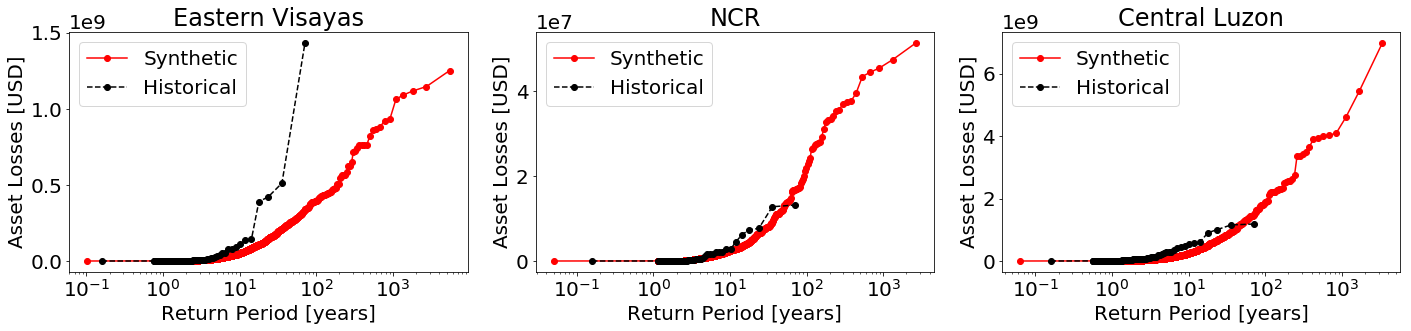

In [9]:
fig = plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 20})

for i in np.arange(3):
    reg = regions_sel[i]
    ax = plt.subplot(1,3,i+1)
    obsw = vector_assets[reg]
    obsy = period_years[reg]
    pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    dot, = ax.semilogx(returnP_o[:],bins[:-1],'r-',marker='o',label='Synthetic')
    
    obsw = asset_losses_hist[reg]
    obsy = period_years_hist[reg]
    pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    dot, = ax.semilogx(returnP_o[:],bins[:-1],'k--',marker='o',label='Historical')
    
    plt.title(reg)
    plt.xlabel('Return Period [years]')
    plt.ylabel('Asset Losses [USD]')
    plt.legend()

plt.tight_layout()

#plt.savefig('FIGURES/asset_losses_exceedance.png',dpi=400)

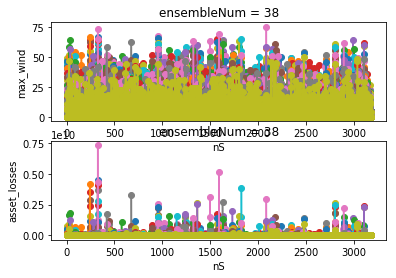

In [4]:
dat = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/CHAZ/ERAInterim_WPC/PHI_REGION_METRICS/NCR.nc')
plt.subplot(212)
for i in range(dat.ensembleNum.max().values):
    dat.sel(ensembleNum=i).asset_losses.plot(marker='o')
plt.subplot(211)
for i in range(dat.ensembleNum.max().values):
    dat.sel(ensembleNum=i).max_wind.plot(marker='o')


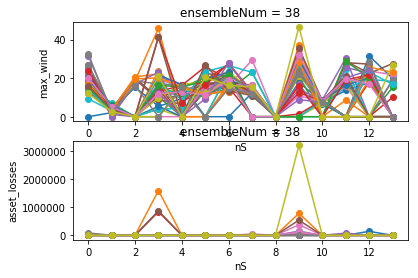

In [6]:
dat = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/CHAZ/ERAInterim_WPC/PHI_REGION_METRICS/OLD/EasternVisayas.nc')
plt.subplot(212)
for i in range(dat.ensembleNum.max().values):
    dat.sel(ensembleNum=i).asset_losses.plot(marker='o')
plt.subplot(211)
for i in range(dat.ensembleNum.max().values):
    dat.sel(ensembleNum=i).max_wind.plot(marker='o')

In [19]:
dat.dyear

<xarray.DataArray 'dyear' (ensembleNum: 40)>
array([0.625, 1.875, 1.875, 1.875, 1.25 , 3.75 , 1.25 , 1.875, 1.875, 1.25 ,
       0.625, 1.875, 1.25 , 0.625, 1.875, 2.5  , 1.25 , 0.625, 1.25 , 1.25 ,
       1.25 , 3.125, 0.625, 0.625, 2.5  , 0.625, 1.25 , 1.875, 0.625, 2.5  ,
       1.875, 0.625, 1.25 , 2.5  , 1.875, 2.5  , 0.625, 1.875, 1.875, 3.125])
Coordinates:
  * ensembleNum  (ensembleNum) int64 0 1 2 3 4 5 6 7 ... 32 33 34 35 36 37 38 39